# Hierarchical Clustering Analysis - Video Games Dataset

This notebook demonstrates hierarchical clustering techniques on a video games dataset with emphasis on the importance of data standardization.

## Objectives:
1. Compare clustering results with and without standardization
2. Visualize dendrograms and cluster formations
3. Understand the impact of feature scaling on distance-based algorithms
4. Apply PCA for 2D visualization of clusters

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"Random state set to: {RANDOM_STATE}")

Libraries imported successfully!
Random state set to: 1234


## 2. Data Loading and Preparation

In [2]:
print("1. DATA PREPARATION")
print("-" * 50)

try:
    sampled_data = pd.read_csv('sampled_video_games.csv')
    print(f"Sampled data loaded: {sampled_data.shape}")
except FileNotFoundError:
    print("Sampled data not found. Reading original data and creating sample...")
    data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
    sampled_data = data.sample(n=2000, random_state=RANDOM_STATE)
    sampled_data.to_csv('sampled_video_games.csv', index=False)
    print(f"New sampled data created: {sampled_data.shape}")

print("\nDataset info:")
print(sampled_data.info())

print("\nFirst 5 rows:")
sampled_data.head()

1. DATA PREPARATION
--------------------------------------------------
Sampled data loaded: (2000, 16)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             2000 non-null   object 
 1   Platform         2000 non-null   object 
 2   Year_of_Release  1965 non-null   float64
 3   Genre            2000 non-null   object 
 4   Publisher        1991 non-null   object 
 5   NA_Sales         2000 non-null   float64
 6   EU_Sales         2000 non-null   float64
 7   JP_Sales         2000 non-null   float64
 8   Other_Sales      2000 non-null   float64
 9   Global_Sales     2000 non-null   float64
 10  Critic_Score     999 non-null    float64
 11  Critic_Count     999 non-null    float64
 12  User_Score       1231 non-null   object 
 13  User_Count       920 non-null    float64
 14  Developer        1235 non-null   o

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Shitsuji ga Aruji o Erabu Toki,PSV,2016.0,Adventure,Unknown,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,Retro Atari Classics,DS,2005.0,Misc,Atari,0.12,0.00,0.00,0.01,0.13,51.0,17.0,3.7,7.0,Taniko,E
2,Blood Bowl,X360,2009.0,Sports,Focus Home Interactive,0.13,0.02,0.00,0.01,0.16,61.0,28.0,5.1,19.0,Cyanide,T
3,Little League World Series Baseball 2009,Wii,2009.0,Sports,Activision,0.14,0.00,0.00,0.01,0.15,NaN,NaN,tbd,NaN,Now Production,E
4,Pipe Mania,PSP,2008.0,Puzzle,Empire Interactive,0.06,0.00,0.00,0.01,0.07,74.0,6.0,tbd,NaN,Empire Interactive,E


In [3]:

missing_values = sampled_data.isnull().sum()
print("Missing values count:")
print(missing_values[missing_values > 0])

print("\nSelecting numerical features for clustering...")
numerical_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 
                     'Year_of_Release', 'Critic_Score', 'User_Count']

print(f"Selected features: {numerical_features}")

clustering_data = sampled_data[numerical_features].copy()

print(f"\nClustering data shape: {clustering_data.shape}")

Missing values count:
Year_of_Release      35
Publisher             9
Critic_Score       1001
Critic_Count       1001
User_Score          769
User_Count         1080
Developer           765
Rating              778
dtype: int64

Selecting numerical features for clustering...
Selected features: ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year_of_Release', 'Critic_Score', 'User_Count']

Clustering data shape: (2000, 8)


## 3. Data Preprocessing

In [4]:

if 'User_Score' in clustering_data.columns:
    clustering_data['User_Score'] = pd.to_numeric(clustering_data['User_Score'], errors='coerce')

print("Filling missing values with median...")
imputer = SimpleImputer(strategy='median')
clustering_data_imputed = pd.DataFrame(imputer.fit_transform(clustering_data), 
                                     columns=clustering_data.columns)

print(f"\nPrepared clustering data shape: {clustering_data_imputed.shape}")
print("\nFirst 5 rows of clustering data:")
print(clustering_data_imputed.head())

print("\nStatistical Summary:")
clustering_data_imputed.describe()

Filling missing values with median...

Prepared clustering data shape: (2000, 8)

First 5 rows of clustering data:
   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Year_of_Release  \
0      0.00      0.00      0.01         0.00          0.01           2016.0   
1      0.12      0.00      0.00         0.01          0.13           2005.0   
2      0.13      0.02      0.00         0.01          0.16           2009.0   
3      0.14      0.00      0.00         0.01          0.15           2009.0   
4      0.06      0.00      0.00         0.01          0.07           2008.0   

   Critic_Score  User_Count  
0          71.0        25.0  
1          51.0         7.0  
2          61.0        19.0  
3          71.0        25.0  
4          74.0        25.0  

Statistical Summary:


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Year_of_Release,Critic_Score,User_Count
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.322650,0.173425,0.090190,0.056930,0.643340,2006.581500,69.873000,85.506500
std,1.446717,0.830259,0.392064,0.340386,2.661425,5.756555,10.280453,319.442321
min,0.000000,0.000000,0.000000,0.000000,0.010000,1981.000000,19.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000,2003.000000,71.000000,25.000000
50%,0.080000,0.020000,0.000000,0.010000,0.170000,2007.000000,71.000000,25.000000
75%,0.240000,0.120000,0.040000,0.030000,0.460000,2010.000000,71.000000,25.000000
max,41.360000,28.960000,6.810000,10.570000,82.530000,2016.000000,97.000000,5380.000000


## 4. Standardization Analysis


2. STANDARDIZATION ANALYSIS
--------------------------------------------------
Values before standardization:

Standardizing the data...
Values after standardization:


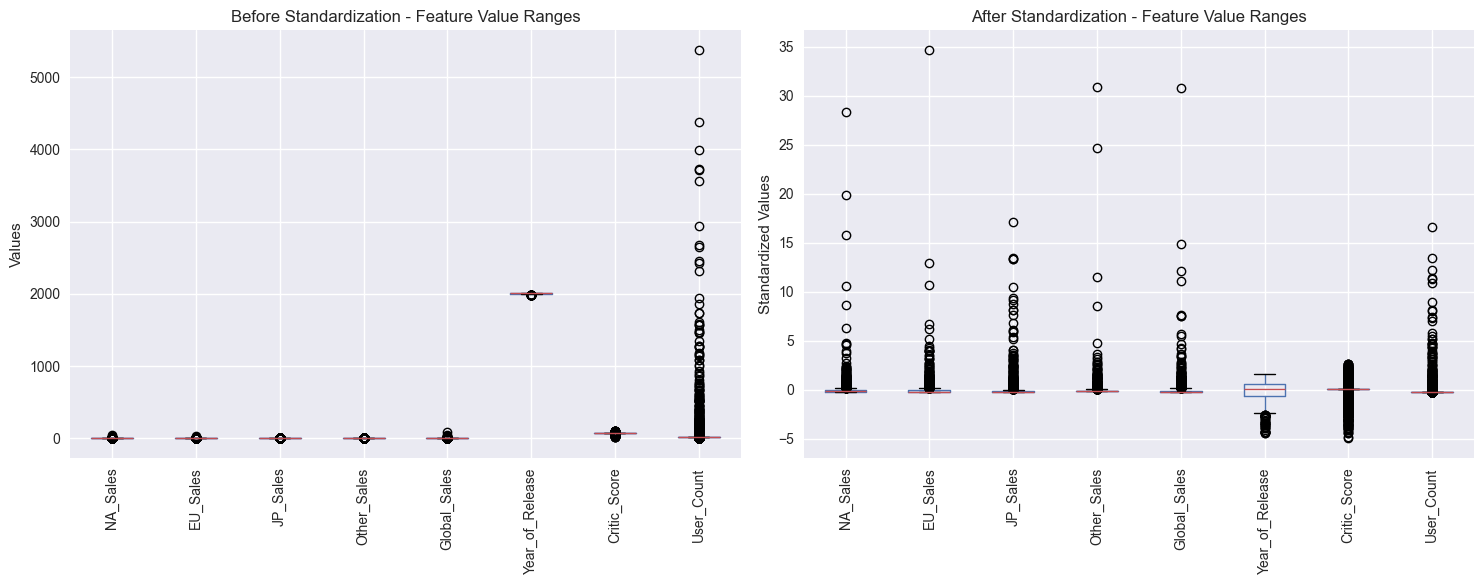


Standardization completed!
Mean after standardization: NA_Sales           0.0
EU_Sales          -0.0
JP_Sales           0.0
Other_Sales       -0.0
Global_Sales       0.0
Year_of_Release   -0.0
Critic_Score      -0.0
User_Count        -0.0
dtype: float64
Std after standardization: NA_Sales           1.00025
EU_Sales           1.00025
JP_Sales           1.00025
Other_Sales        1.00025
Global_Sales       1.00025
Year_of_Release    1.00025
Critic_Score       1.00025
User_Count         1.00025
dtype: float64


In [5]:
print("\n2. STANDARDIZATION ANALYSIS")
print("-" * 50)

print("Values before standardization:")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
clustering_data_imputed.boxplot(ax=plt.gca())
plt.title('Before Standardization - Feature Value Ranges')
plt.xticks(rotation=90)
plt.ylabel('Values')

print("\nStandardizing the data...")
scaler = StandardScaler()
clustering_data_scaled = pd.DataFrame(scaler.fit_transform(clustering_data_imputed),
                                     columns=clustering_data_imputed.columns)

print("Values after standardization:")
plt.subplot(1, 2, 2)
clustering_data_scaled.boxplot(ax=plt.gca())
plt.title('After Standardization - Feature Value Ranges')
plt.xticks(rotation=90)
plt.ylabel('Standardized Values')

plt.tight_layout()
plt.show()

print("\nStandardization completed!")
print(f"Mean after standardization: {clustering_data_scaled.mean().round(10)}")
print(f"Std after standardization: {clustering_data_scaled.std().round(10)}")

## 5. Sample Data for Clustering

For computational efficiency and clearer dendrogram visualization, we'll work with a sample of the data.

In [6]:

n_samples = min(500, len(clustering_data_imputed))  

print(f"Sampling {n_samples} examples for clustering analysis...")

sample_indices = np.random.choice(len(clustering_data_imputed), n_samples, replace=False)
data_sample = clustering_data_imputed.iloc[sample_indices]
data_sample_scaled = clustering_data_scaled.iloc[sample_indices]

print(f"Sample data shape: {data_sample.shape}")
print(f"Sample scaled data shape: {data_sample_scaled.shape}")

print("\nSample data statistics (before standardization):")
print(data_sample.describe())

print("\nSample data statistics (after standardization):")
print(data_sample_scaled.describe())

Sampling 500 examples for clustering analysis...
Sample data shape: (500, 8)
Sample scaled data shape: (500, 8)

Sample data statistics (before standardization):
         NA_Sales   EU_Sales    JP_Sales  Other_Sales  Global_Sales  \
count  500.000000  500.00000  500.000000   500.000000    500.000000   
mean     0.242080    0.14826    0.080640     0.042620      0.513860   
std      0.446934    0.41119    0.276086     0.100831      0.957849   
min      0.000000    0.00000    0.000000     0.000000      0.010000   
25%      0.010000    0.00000    0.000000     0.000000      0.067500   
50%      0.090000    0.02000    0.000000     0.010000      0.170000   
75%      0.242500    0.12000    0.030000     0.030000      0.440000   
max      3.560000    5.75000    3.670000     1.110000      7.590000   

       Year_of_Release  Critic_Score   User_Count  
count       500.000000    500.000000   500.000000  
mean       2006.862000     69.478000    97.314000  
std           5.442996     10.805509   328

## 6. Hierarchical Clustering - Without Standardization


3. HIERARCHICAL CLUSTERING - WITHOUT STANDARDIZATION
--------------------------------------------------
Applying hierarchical clustering without standardization (500 samples)...


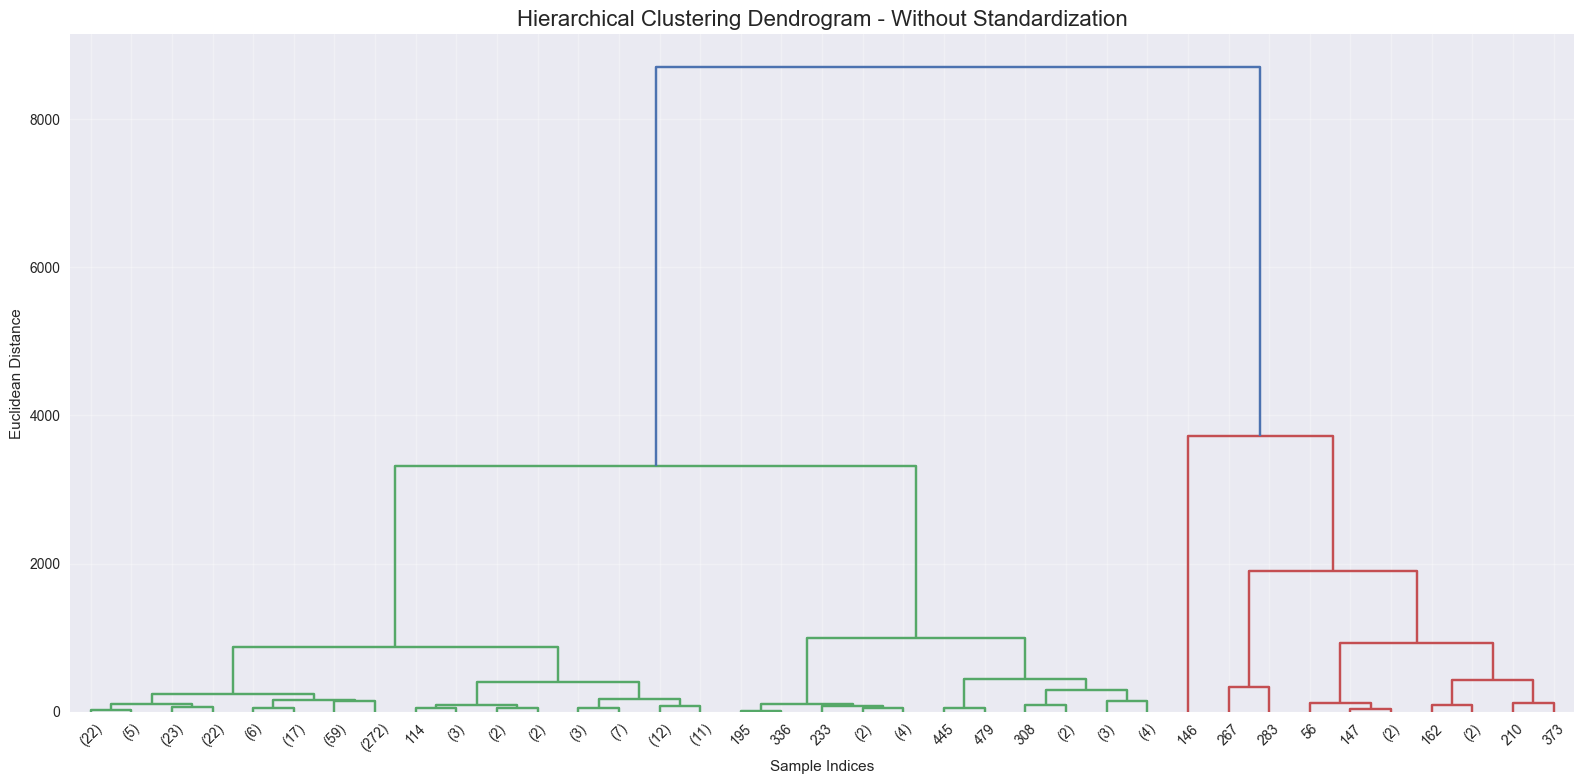

Dendrogram without standardization completed.
Note: Large distances indicate that features with larger scales dominate the clustering.


In [7]:
print("\n3. HIERARCHICAL CLUSTERING - WITHOUT STANDARDIZATION")
print("-" * 50)

print(f"Applying hierarchical clustering without standardization ({n_samples} samples)...")

Z_without_scaling = linkage(data_sample, method='ward')

plt.figure(figsize=(16, 8))
plt.title('Hierarchical Clustering Dendrogram - Without Standardization', fontsize=16)
dendrogram(Z_without_scaling, truncate_mode='level', p=5, leaf_font_size=10)
plt.xlabel('Sample Indices')
plt.ylabel('Euclidean Distance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Dendrogram without standardization completed.")
print("Note: Large distances indicate that features with larger scales dominate the clustering.")

## 7. Hierarchical Clustering - With Standardization


4. HIERARCHICAL CLUSTERING - WITH STANDARDIZATION
--------------------------------------------------
Applying hierarchical clustering with standardization (500 samples)...


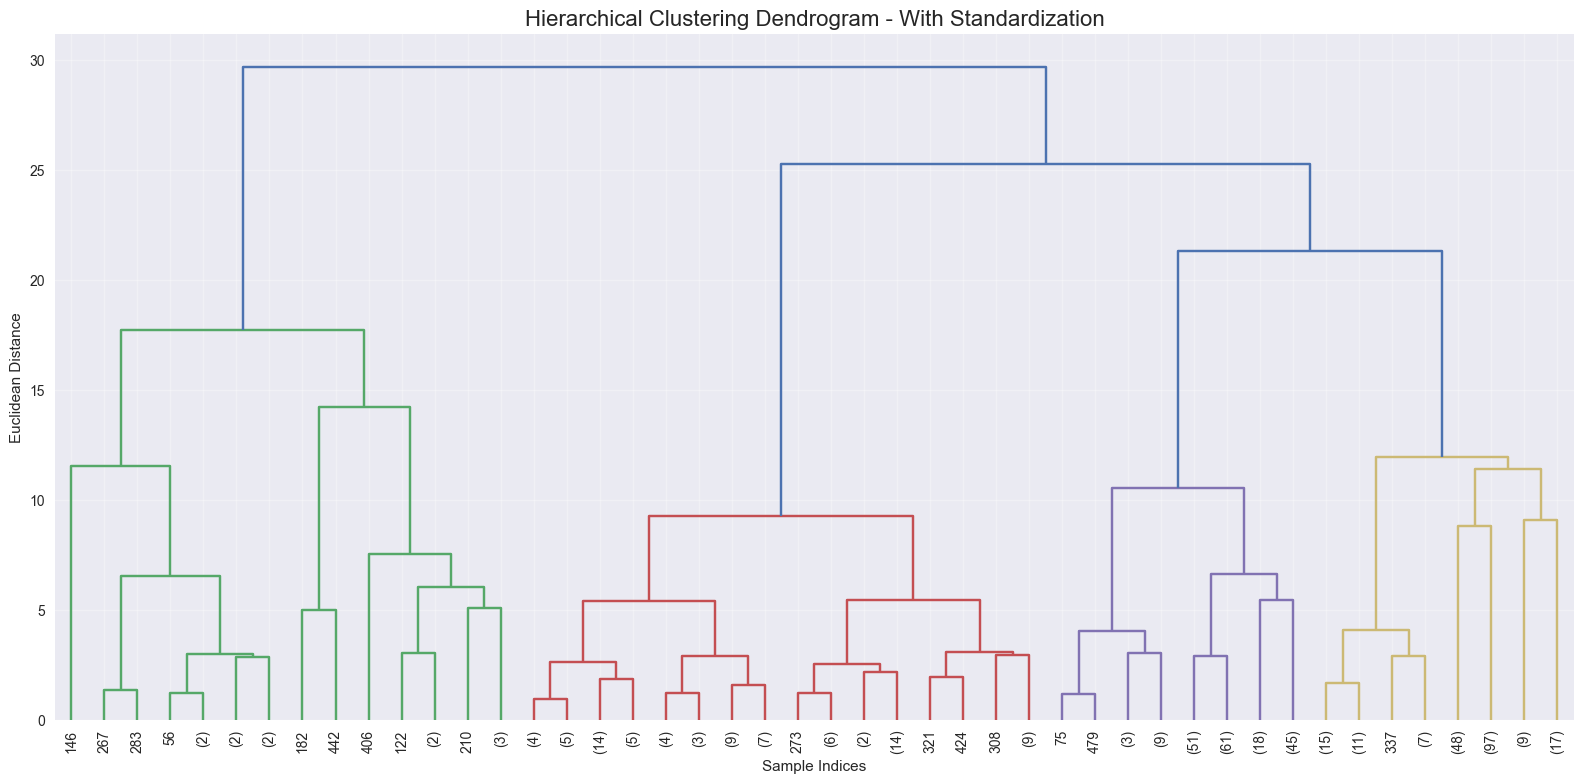

Dendrogram with standardization completed.
Note: More balanced distances indicate all features contribute equally to clustering.


In [8]:
print("\n4. HIERARCHICAL CLUSTERING - WITH STANDARDIZATION")
print("-" * 50)

print(f"Applying hierarchical clustering with standardization ({n_samples} samples)...")

Z_with_scaling = linkage(data_sample_scaled, method='ward')

plt.figure(figsize=(16, 8))
plt.title('Hierarchical Clustering Dendrogram - With Standardization', fontsize=16)
dendrogram(Z_with_scaling, truncate_mode='level', p=5, leaf_font_size=10)
plt.xlabel('Sample Indices')
plt.ylabel('Euclidean Distance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Dendrogram with standardization completed.")
print("Note: More balanced distances indicate all features contribute equally to clustering.")

## 8. Compare Dendrogram Structures

DENDROGRAM DISTANCE COMPARISON:
Without Standardization:
  Min distance: 0.00
  Max distance: 8706.08
  Range: 8706.08

With Standardization:
  Min distance: 0.00
  Max distance: 29.68
  Range: 29.68


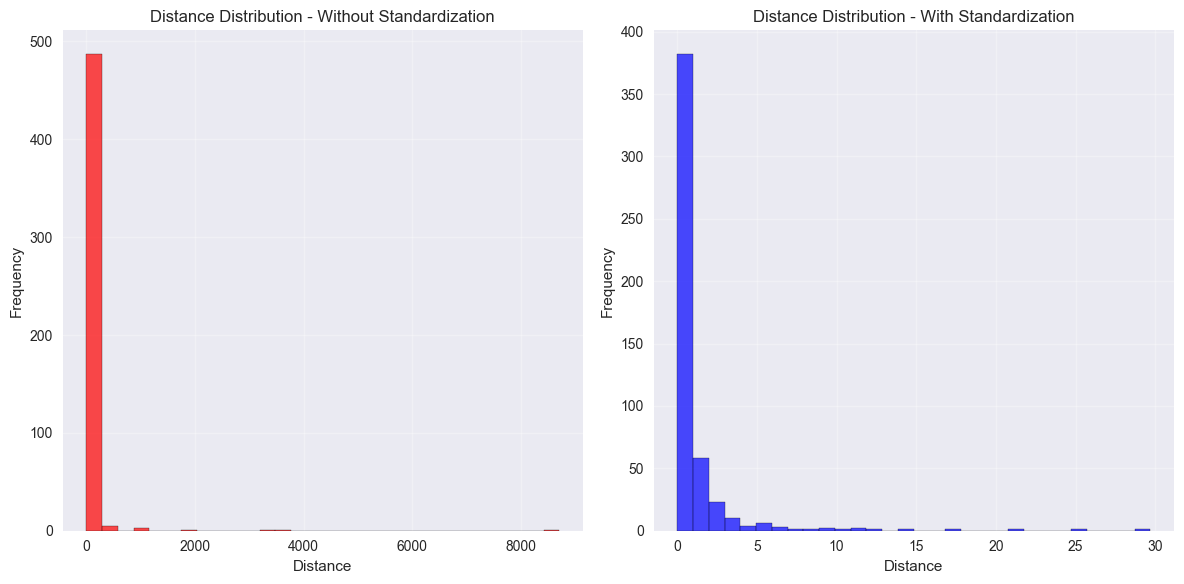

In [9]:

distances_without = Z_without_scaling[:, 2]
distances_with = Z_with_scaling[:, 2]

print("DENDROGRAM DISTANCE COMPARISON:")
print("=" * 40)
print(f"Without Standardization:")
print(f"  Min distance: {distances_without.min():.2f}")
print(f"  Max distance: {distances_without.max():.2f}")
print(f"  Range: {distances_without.max() - distances_without.min():.2f}")

print(f"\nWith Standardization:")
print(f"  Min distance: {distances_with.min():.2f}")
print(f"  Max distance: {distances_with.max():.2f}")
print(f"  Range: {distances_with.max() - distances_with.min():.2f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(distances_without, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distance Distribution - Without Standardization')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(distances_with, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distance Distribution - With Standardization')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 2D Visualization and Cluster Comparison

In [10]:
print("\n5. 2D VISUALIZATION AND CLUSTER COMPARISON")
print("-" * 50)

print("Reducing dimensionality to 2D using PCA...")
pca = PCA(n_components=2)
data_2d_without_scaling = pca.fit_transform(data_sample)
pca_variance_without = pca.explained_variance_ratio_

pca_scaled = PCA(n_components=2)
data_2d_with_scaling = pca_scaled.fit_transform(data_sample_scaled)
pca_variance_with = pca_scaled.explained_variance_ratio_

print(f"PCA without standardization - Explained variance: {pca_variance_without.sum():.2%}")
print(f"PCA with standardization - Explained variance: {pca_variance_with.sum():.2%}")

n_clusters = 4
print(f"\nApplying AgglomerativeClustering with {n_clusters} clusters...")

model_without_scaling = AgglomerativeClustering(n_clusters=n_clusters)
clusters_without_scaling = model_without_scaling.fit_predict(data_sample)

model_with_scaling = AgglomerativeClustering(n_clusters=n_clusters)
clusters_with_scaling = model_with_scaling.fit_predict(data_sample_scaled)

print("Clustering completed for both approaches.")


5. 2D VISUALIZATION AND CLUSTER COMPARISON
--------------------------------------------------
Reducing dimensionality to 2D using PCA...
PCA without standardization - Explained variance: 99.97%
PCA with standardization - Explained variance: 61.13%

Applying AgglomerativeClustering with 4 clusters...
Clustering completed for both approaches.


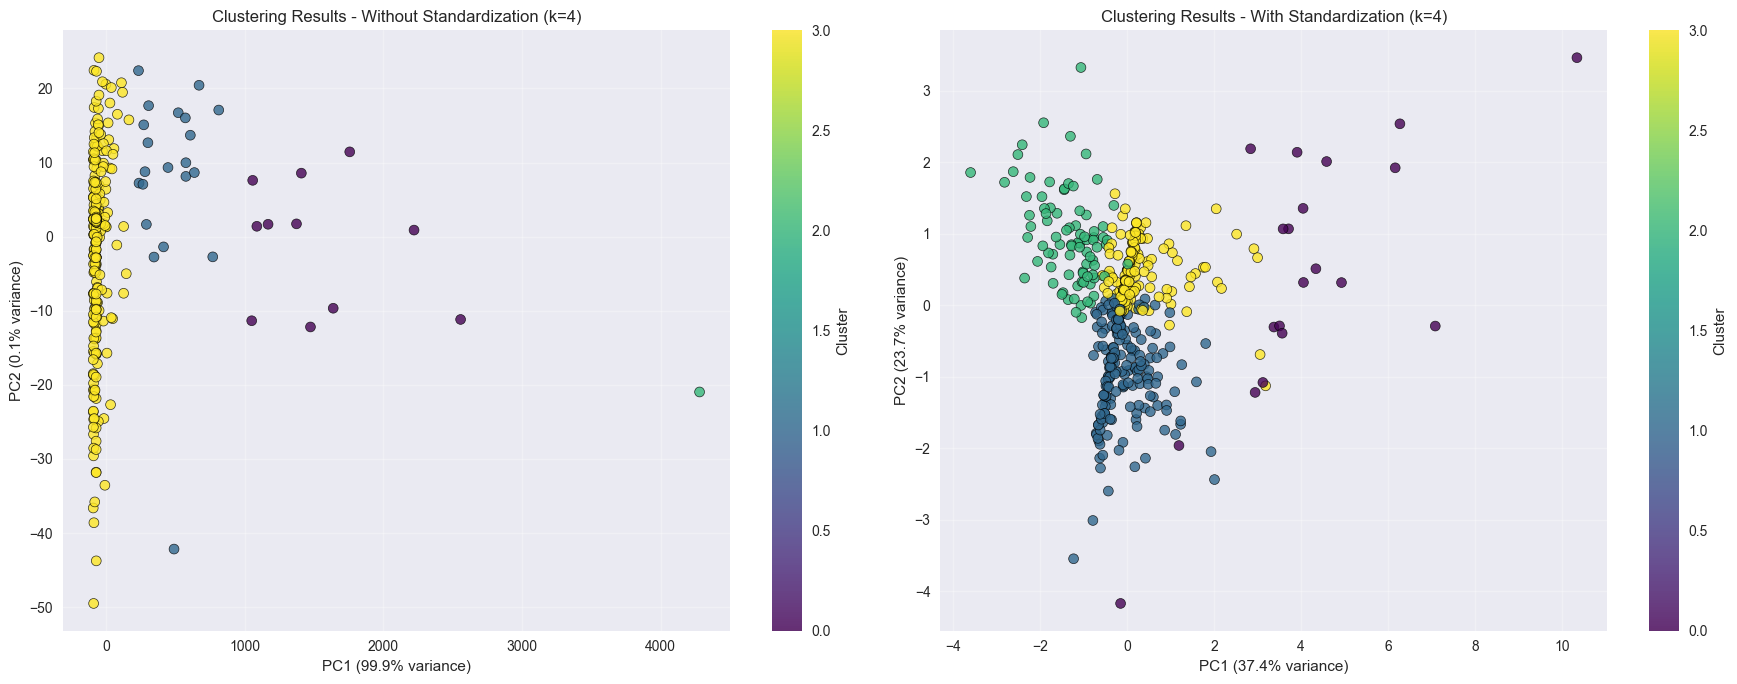


Cluster distribution comparison:
Without standardization:
  Cluster 0: 11 samples (2.2%)
  Cluster 1: 21 samples (4.2%)
  Cluster 2: 1 samples (0.2%)
  Cluster 3: 467 samples (93.4%)

With standardization:
  Cluster 0: 20 samples (4.0%)
  Cluster 1: 205 samples (41.0%)
  Cluster 2: 86 samples (17.2%)
  Cluster 3: 189 samples (37.8%)


In [11]:

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(data_2d_without_scaling[:, 0], data_2d_without_scaling[:, 1], 
                      c=clusters_without_scaling, cmap='viridis', alpha=0.8, s=50, 
                      edgecolors='black', linewidth=0.5)
plt.title(f'Clustering Results - Without Standardization (k={n_clusters})')
plt.xlabel(f'PC1 ({pca_variance_without[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_variance_without[1]:.1%} variance)')
plt.colorbar(scatter1, label='Cluster')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(data_2d_with_scaling[:, 0], data_2d_with_scaling[:, 1], 
                      c=clusters_with_scaling, cmap='viridis', alpha=0.8, s=50,
                      edgecolors='black', linewidth=0.5)
plt.title(f'Clustering Results - With Standardization (k={n_clusters})')
plt.xlabel(f'PC1 ({pca_variance_with[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_variance_with[1]:.1%} variance)')
plt.colorbar(scatter2, label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCluster distribution comparison:")
print("Without standardization:")
unique_without, counts_without = np.unique(clusters_without_scaling, return_counts=True)
for cluster, count in zip(unique_without, counts_without):
    print(f"  Cluster {cluster}: {count} samples ({count/len(clusters_without_scaling)*100:.1f}%)")

print("\nWith standardization:")
unique_with, counts_with = np.unique(clusters_with_scaling, return_counts=True)
for cluster, count in zip(unique_with, counts_with):
    print(f"  Cluster {cluster}: {count} samples ({count/len(clusters_with_scaling)*100:.1f}%)")

## 10. Cluster Analysis and Interpretation

In [12]:

print("\nCLUSTER CHARACTERISTICS ANALYSIS")
print("=" * 40)

analysis_data_without = data_sample.copy()
analysis_data_without['Cluster'] = clusters_without_scaling

analysis_data_with = data_sample.copy()
analysis_data_with['Cluster'] = clusters_with_scaling

print("\nMean values by cluster - WITHOUT standardization:")
cluster_means_without = analysis_data_without.groupby('Cluster').mean()
print(cluster_means_without.round(2))

print("\nMean values by cluster - WITH standardization:")
cluster_means_with = analysis_data_with.groupby('Cluster').mean()
print(cluster_means_with.round(2))


CLUSTER CHARACTERISTICS ANALYSIS

Mean values by cluster - WITHOUT standardization:
         NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
Cluster                                                            
0            0.97      0.88      0.23         0.23          2.32   
1            0.83      0.92      0.17         0.23          2.15   
2            0.25      0.56      0.00         0.14          0.96   
3            0.20      0.10      0.07         0.03          0.40   

         Year_of_Release  Critic_Score  User_Count  
Cluster                                             
0                2013.09         82.64     1623.36  
1                2011.71         81.57      554.76  
2                2011.00         88.00     4378.00  
3                2006.49         68.58       31.63  

Mean values by cluster - WITH standardization:
         NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
Cluster                                                            
0   

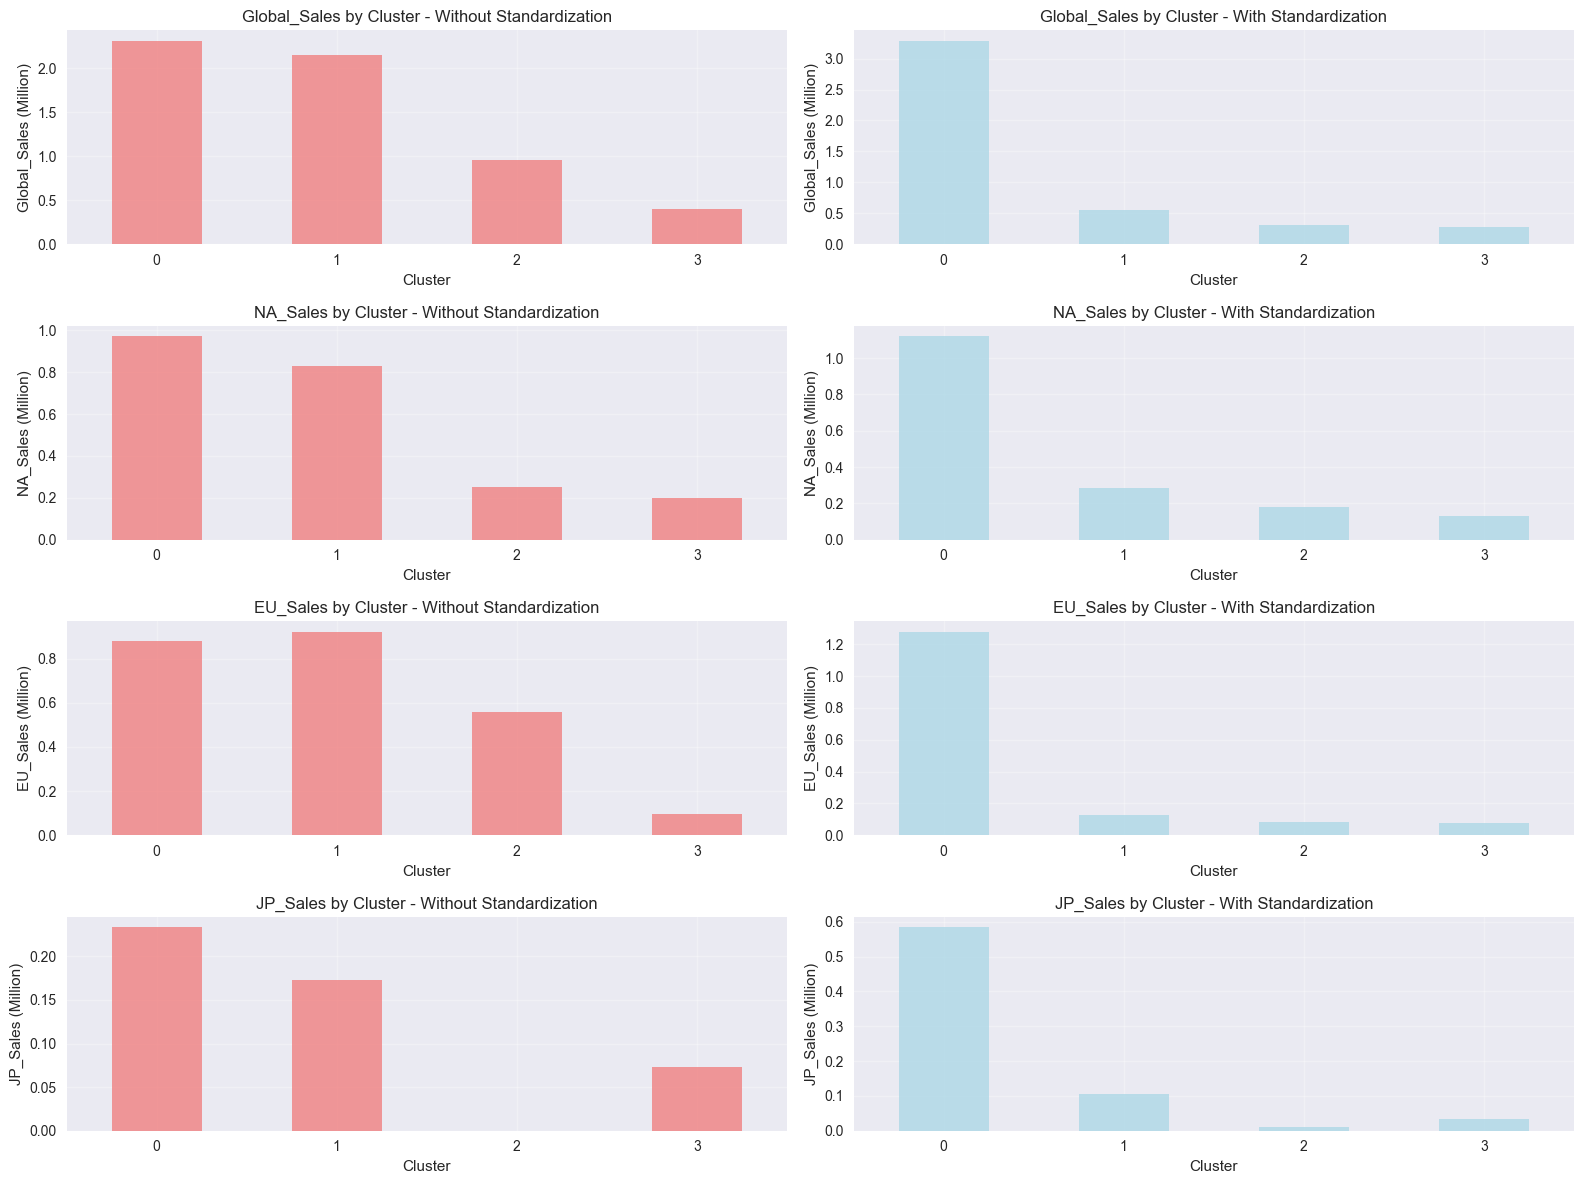

In [13]:

plt.figure(figsize=(16, 12))

key_features = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales']

for i, feature in enumerate(key_features):
   
    plt.subplot(4, 2, i*2 + 1)
    cluster_means_without[feature].plot(kind='bar', color='lightcoral', alpha=0.8)
    plt.title(f'{feature} by Cluster - Without Standardization')
    plt.ylabel(f'{feature} (Million)')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
   
    plt.subplot(4, 2, i*2 + 2)
    cluster_means_with[feature].plot(kind='bar', color='lightblue', alpha=0.8)
    plt.title(f'{feature} by Cluster - With Standardization')
    plt.ylabel(f'{feature} (Million)')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluation and Comparison


CLUSTERING EVALUATION
Silhouette Score without standardization: 0.9063
Silhouette Score with standardization: 0.3004

⚠️ Standardization does not improve clustering quality in this case.

Testing different numbers of clusters...


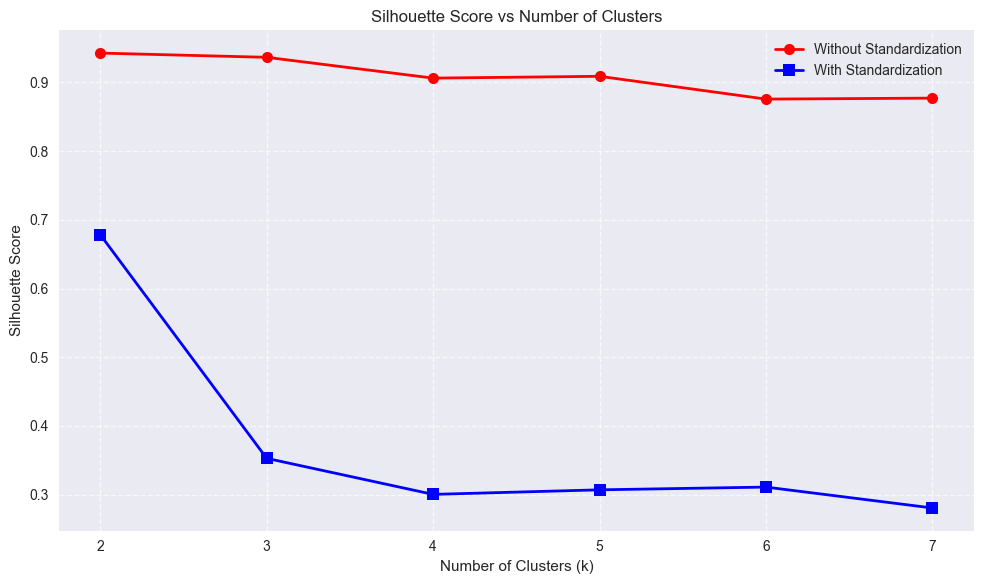


Optimal number of clusters without standardization: 2
Optimal number of clusters with standardization: 2
Best silhouette score without standardization: 0.9428
Best silhouette score with standardization: 0.6784


In [14]:

from sklearn.metrics import silhouette_score

print("\nCLUSTERING EVALUATION")
print("=" * 30)

# Silhouette scores
silhouette_without = silhouette_score(data_sample, clusters_without_scaling)
silhouette_with = silhouette_score(data_sample_scaled, clusters_with_scaling)

print(f"Silhouette Score without standardization: {silhouette_without:.4f}")
print(f"Silhouette Score with standardization: {silhouette_with:.4f}")

if silhouette_with > silhouette_without:
    print("\n✅ Standardization improves clustering quality!")
else:
    print("\n⚠️ Standardization does not improve clustering quality in this case.")

print("\nTesting different numbers of clusters...")
k_range = range(2, 8)
silhouette_scores_without = []
silhouette_scores_with = []

for k in k_range:
    clusters_k_without = AgglomerativeClustering(n_clusters=k).fit_predict(data_sample)
    score_without = silhouette_score(data_sample, clusters_k_without)
    silhouette_scores_without.append(score_without)
    
    clusters_k_with = AgglomerativeClustering(n_clusters=k).fit_predict(data_sample_scaled)
    score_with = silhouette_score(data_sample_scaled, clusters_k_with)
    silhouette_scores_with.append(score_with)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_without, marker='o', linestyle='-', 
         linewidth=2, markersize=8, label='Without Standardization', color='red')
plt.plot(k_range, silhouette_scores_with, marker='s', linestyle='-', 
         linewidth=2, markersize=8, label='With Standardization', color='blue')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

optimal_k_without = k_range[np.argmax(silhouette_scores_without)]
optimal_k_with = k_range[np.argmax(silhouette_scores_with)]

print(f"\nOptimal number of clusters without standardization: {optimal_k_without}")
print(f"Optimal number of clusters with standardization: {optimal_k_with}")
print(f"Best silhouette score without standardization: {max(silhouette_scores_without):.4f}")
print(f"Best silhouette score with standardization: {max(silhouette_scores_with):.4f}")

## 12. Summary and Conclusions


6. RESULTS AND EVALUATION
--------------------------------------------------
Feature value ranges (before standardization):
  NA_Sales: 3.56
  EU_Sales: 5.75
  JP_Sales: 3.67
  Other_Sales: 1.11
  Global_Sales: 7.58
  Year_of_Release: 35.00
  Critic_Score: 78.00
  User_Count: 4374.00

Dominant feature: User_Count (range: 4374.00)


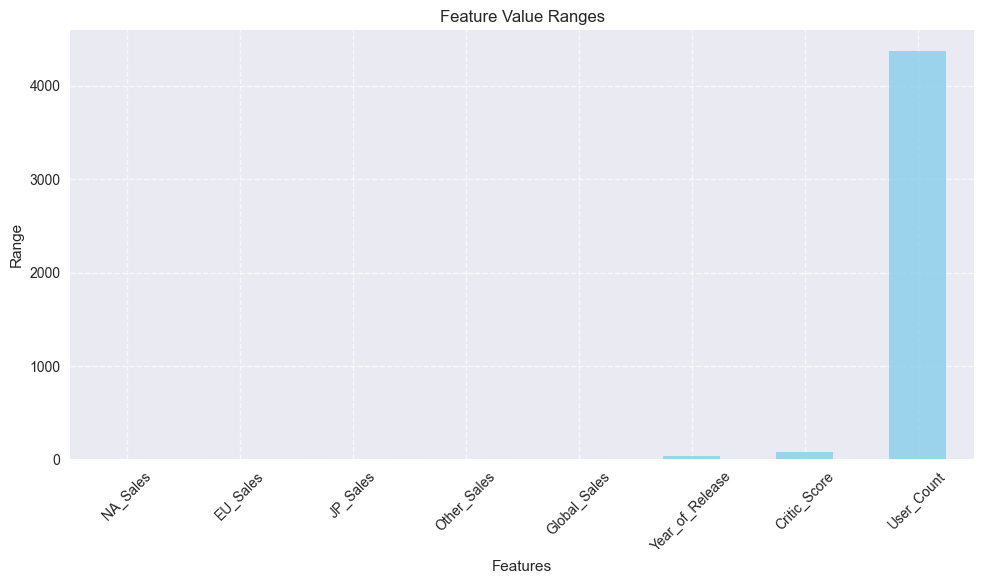

In [15]:
print("\n6. RESULTS AND EVALUATION")
print("-" * 50)

feature_ranges = data_sample.max() - data_sample.min()
print("Feature value ranges (before standardization):")
for feature, range_val in feature_ranges.items():
    print(f"  {feature}: {range_val:.2f}")

max_range_feature = feature_ranges.idxmax()
max_range_value = feature_ranges.max()
print(f"\nDominant feature: {max_range_feature} (range: {max_range_value:.2f})")

plt.figure(figsize=(10, 6))
feature_ranges.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Feature Value Ranges')
plt.xlabel('Features')
plt.ylabel('Range')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()